# Practice: Dilated CNN model

In this notebook, we work through implementing a CNN for forecasting. The notebook covers:
- prepare time series data for training a Convolutional Neural Network (CNN) forecasting model
- get data in the required shape for the keras API
- implement a CNN model in keras to predict 3 steps ahead (time *t+1* to *t+1*) in the time series
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

import numpy as np
np.set_printoptions(precision=2)

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Load the data from `data/energy.parquet` into a Pandas dataframe

In [2]:
import os

# Insert code START
file_name = os.path.join('data', 'energy.parquet')
energy = pd.read_parquet(file_name)
# Insert code END
assert energy.shape == (26304, 2)
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


Load and temperature in first week of July 2014

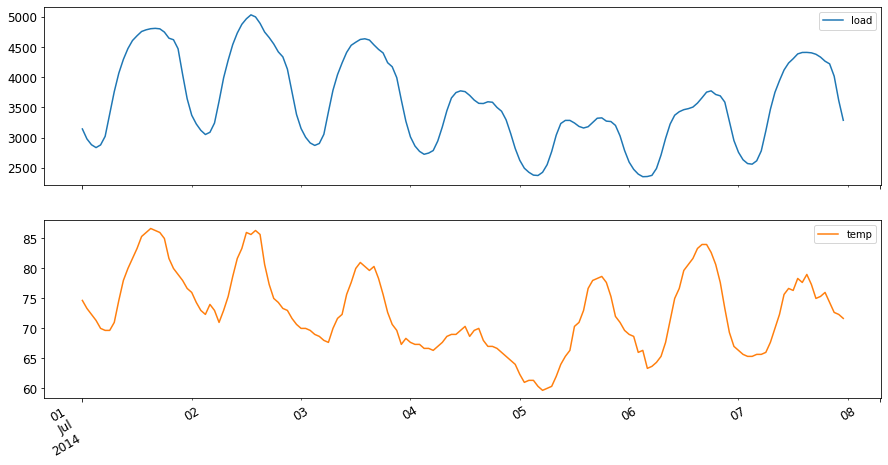

In [3]:
energy['2014-07-01':'2014-07-07'].plot(y=['load', 'temp'], subplots=True, figsize=(15, 8), fontsize=12)
plt.show()

## Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

Allocate the period 1st November 2014 to 31st December 2014 to the test set, and the period 1st September 2014 to 31st October to the validation set. All other time periods are designated for the training set.

In [4]:
# Insert code START
valid_start_dt = '2014-08-31 23:30:00'
test_start_dt = '2014-10-31 23:30:00'
# Insert code END

train = energy.copy()[:valid_start_dt]
valid = energy.copy()[valid_start_dt:test_start_dt]
test = energy.copy()[test_start_dt:]

assert train.index.max() == pd.to_datetime('2014-08-31 23:00:00')
assert valid.index.min() == pd.to_datetime('2014-09-01 00:00:00')
assert valid.index.max() == pd.to_datetime('2014-10-31 23:00:00')
assert test.index.min() == pd.to_datetime('2014-11-01 00:00:00')

## Data preparation

For this example, we will set *T=24*. This means that the input for each sample is a vector of the prevous 24 hours of the energy load.

*HORIZON=3* specifies that we have a forecasting horizon of 3 (*t+1* to *t+3*)

In [5]:
T = 24
HORIZON = 3

### Data preparation - training set

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Fit a scaler for the y values
y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

# Also scale the input features data (load and temp values)
X_scaler = MinMaxScaler()
train[['load', 'temp']] = X_scaler.fit_transform(train)
valid[['load', 'temp']] = X_scaler.transform(valid)
test[['load', 'temp']] = X_scaler.transform(test)

Use the TimeSeriesTensor convenience class to:
1. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
2. Discard any samples with missing values
3. Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [7]:
from common.utils import TimeSeriesTensor

tensor_structure = {'X':(range(-T+1, 1), ['load', 'temp'])}
train_inputs = TimeSeriesTensor(dataset=train,
                            target='load',
                            H=HORIZON,
                            tensor_structure=tensor_structure,
                            freq='H',
                            drop_incomplete=True)


X_train = train_inputs['X']
y_train = train_inputs['target']

assert y_train.shape == (23350, 3)
assert X_train.shape == (23350, 24, 2)

#### Data preparation - validation set
Create a `TimeSeriesTensor` from the validation dataset.

In [8]:
# In order to allow T lags, we need to add the last T-1 train samples to the validation set
valid = pd.concat([train.iloc[-(T-1):], valid])

# Create TimeSeriesTensor
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)
y_valid = valid_inputs['target']
X_valid = valid_inputs['X']

assert y_valid.shape == (1461, 3)
assert X_valid.shape == (1461, 24, 2)

## Implement a multivariate CNN

In [9]:
from keras.models import Model, Sequential
from keras.layers import Conv1D, Dense, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


#### Fill in your code below and replace the question marks

Implement your CNN model with the data prepared above and the following requirements:
1. Use 2 features: past load and temperature
2. Stack 5 convolutional layers of kernel width 2 with dilation rates 1, 2, 4, 8, 16
3. Use 5 filters in each layer
4. Train for 10 epochs
5. Batch size 32

In [13]:
# Insert code START
LATENT_DIM = 5
KERNEL_SIZE = 2
BATCH_SIZE = 32
EPOCHS = 15
# Insert code END

In [11]:
# Fill in your code below
model = Sequential()
# Insert code START
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=1, input_shape=(T, 2)))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=2))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=4))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=8))
model.add(Conv1D(LATENT_DIM, kernel_size=KERNEL_SIZE, padding='causal', strides=1, activation='relu', dilation_rate=16))
model.add(Flatten())
model.add(Dense(HORIZON, activation='linear'))
# Insert code END

Once you done, run the rest of the notebook to check if your model works.

In [12]:
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 24, 5)             25        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 24, 5)             55        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 24, 5)             55        
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 24, 5)             55        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 24, 5)             55        
_________________________________________________________________
flatten_1 (Flatten)          (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                

Specify the early stopping criteria. We **monitor** the validation loss (in this case the mean squared error) on the validation set after each training epoch. If the validation loss has not improved by **min_delta** after **patience** epochs, we stop the training.

In [14]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Train on 23350 samples, validate on 1461 samples
Epoch 1/15
23350/23350 [==============================] - 2s 91us/step - loss: 0.0129 - val_loss: 0.0034
Epoch 2/15
23350/23350 [==============================] - 2s 76us/step - loss: 0.0047 - val_loss: 0.0028
Epoch 3/15
23350/23350 [==============================] - 2s 76us/step - loss: 0.0038 - val_loss: 0.0025
Epoch 4/15
23350/23350 [==============================] - 2s 76us/step - loss: 0.0030 - val_loss: 0.0017
Epoch 5/15
23350/23350 [==============================] - 2s 76us/step - loss: 0.0024 - val_loss: 0.0019
Epoch 6/15
23350/23350 [==============================] - 2s 77us/step - loss: 0.0020 - val_loss: 0.0011
Epoch 7/15
23350/23350 [==============================] - 2s 78us/step - loss: 0.0018 - val_loss: 0.0011
Epoch 8/15
23350/23350 [==============================] - 2s 79us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 9/15
23350/23350 [==============================] - 2s 79us/step - loss: 0.0014 - val_loss: 0.0027
Epoch 

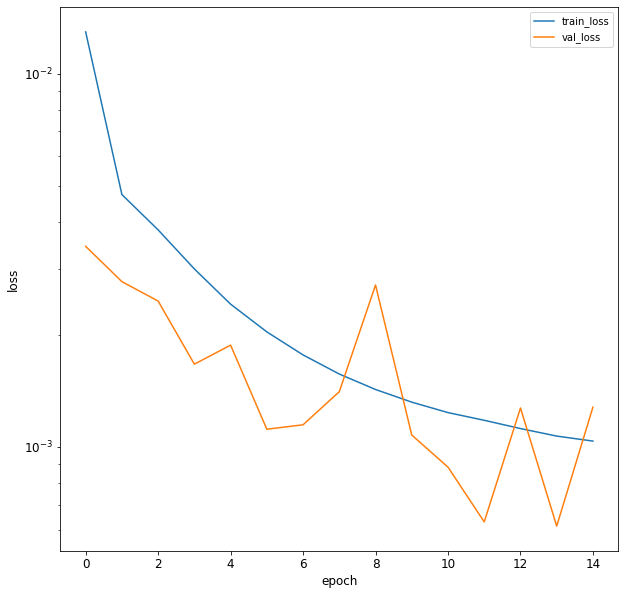

In [15]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## Evaluate the model

Create the test set

In [16]:
# In order to allow T lags, we need to add the last T-1 validation samples to the test set
test = pd.concat([valid.iloc[-(T-1):], test])

# Create TimeSeriesTensor
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)
y_test = test_inputs['target']
X_test = test_inputs['X']

assert y_test.shape == (1461, 3)
assert X_test.shape == (1461, 24, 2)

In [17]:
from common.utils import create_evaluation_df

predictions = model.predict(X_test)
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 00:00:00,t+1,"2,295.07","2,434.00"
1,2014-11-01 01:00:00,t+1,"2,291.66","2,390.00"
2,2014-11-01 02:00:00,t+1,"2,196.85","2,382.00"
3,2014-11-01 03:00:00,t+1,"2,234.75","2,419.00"
4,2014-11-01 04:00:00,t+1,"2,445.99","2,520.00"


Calculate MAPE for each horizon

In [18]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean() * 100

h
t+1   3.26
t+2   3.51
t+3   3.68
Name: APE, dtype: float64

No handles with labels found to put in legend.


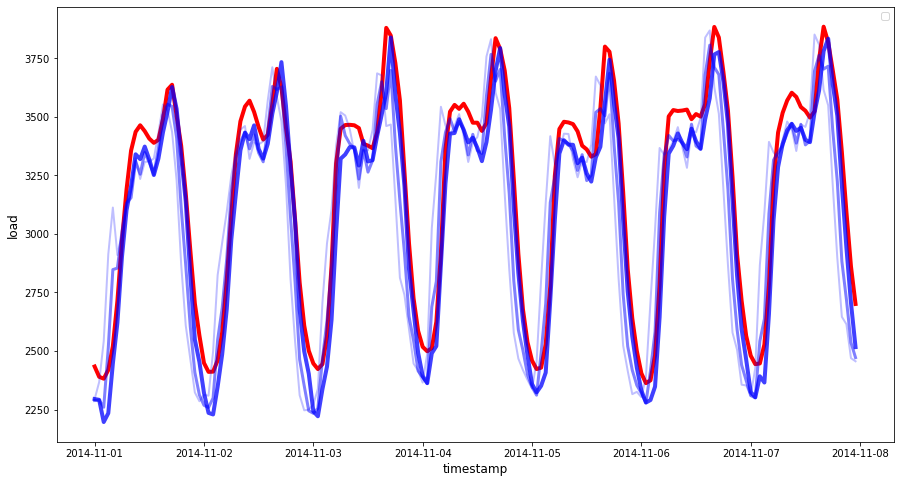

In [19]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()